# Banana collector

---

In this notebook, we will DQN agent to pick up yellow bananas while avoiding blue ones in Unity ML-Agents environment.

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/) or any other necessary packages.

In [1]:
from unityagents import UnityEnvironment

import matplotlib.pyplot as plt
import numpy as np
import torch

Next, we will start the environment!  **_Before running the code cell below_**, change the `project_dir` and `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [9]:
import os.path

home_dir    = os.path.expanduser("~")
project_dir = os.path.join(os.path.sep, home_dir, "Documents", "MyPrograms", "rl", "banana_collector")
file_name   = "Banana_Linux/Banana.x86"

full_path = os.path.join(os.path.sep, project_dir, file_name)


print("Launching Unity from: %s"%full_path)

env = UnityEnvironment(file_name=full_path)


Launching Unity from: /home/slsi/Documents/MyPrograms/rl/banana_collector/Banana_Linux/Banana.x86


OSError: handle is closed

ERROR:root:Exception calling application: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/slsi/anaconda3/envs/drlnd/lib/python3.6/site-packages/grpc/_server.py", line 385, in _call_behavior
    return behavior(argument, context), True
  File "/home/slsi/anaconda3/envs/drlnd/lib/python3.6/site-packages/unityagents/rpc_communicator.py", line 25, in Exchange
    self.child_conn.send(request)
  File "/home/slsi/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/home/slsi/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/slsi/anaconda3/envs/drlnd/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Train DQN agent!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
from dqn_agent import Agent
from collections import deque

agent = Agent(state_size=state_size, action_size=action_size, seed=0)


In [5]:
def dqn(n_episodes=2000, max_t=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Observe current state
        state = env_info.vector_observations[0]  
        
        # Reset score and done flag
        score = 0
        done = False
        
        # Loop each episode
        while not done:
            
            # Select action with e-greedy policy
            action = agent.act(state, eps)
            
            # Take action
            env_info = env.step(action)[brain_name]  
            
            # Observe the next state
            next_state = env_info.vector_observations[0]   
            
            # Get the reward
            reward = env_info.rewards[0]       
            
            # Check if episode is finished
            done = env_info.local_done[0]  
            
            # Store experience
            agent.step(state, action, reward, next_state, done)
            
            # State transition
            state = next_state
            
            # Update total score
            score += reward
            
        # Save most recent score   
        scores_window.append(score)
        scores.append(score)
        
        # Decay epsilon
        eps = max(eps_end, eps_decay*eps) 
        
        # Print learning progress
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
            
    return scores

scores = dqn()

Episode 100	Average Score: 1.10
Episode 200	Average Score: 4.98
Episode 300	Average Score: 8.15
Episode 400	Average Score: 11.02
Episode 481	Average Score: 13.03
Environment solved in 381 episodes!	Average Score: 13.03


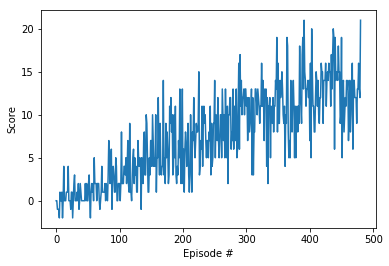

In [6]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [10]:
# close the environment
env.close()

UnityEnvironmentException: No Unity environment is loaded.